This notebook contains the code relating to section 4.4.3 of the thesis: 64-by-64-pixel patch-wise segmentation with transfer learning

## Installations

In [ ]:
pip -q install wandb

     |████████████████████████████████| 1.6 MB 5.5 MB/s 
     |████████████████████████████████| 133 kB 47.7 MB/s 
     |████████████████████████████████| 170 kB 35.5 MB/s 
     |████████████████████████████████| 97 kB 4.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [ ]:
pip -q install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import numpy as np
import nibabel
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from __future__ import print_function

from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io

import keras
from keras.models import Model, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import layers

import wandb
from wandb.keras import WandbCallback

from tqdm.auto import tqdm

os.getcwd()

'/content'

In [ ]:
def get_tpu_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu="grpc://" + os.environ["COLAB_TPU_ADDR"]
        )  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    except ValueError:
        raise BaseException("ERROR: Not connected to a TPU runtime")

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    return tf.distribute.TPUStrategy(tpu)

In [ ]:
tpu_strategy = get_tpu_strategy()

In [ ]:
# give permission to read data from google cloud bucket
from google.colab import auth
auth.authenticate_user()

## Functions for loading data in TFRecords format

In [ ]:
def _parse_image_function(example_proto):

    """
    Reads from TFRecord file
    Returns a tf.train.Example object (can be read like a dictionary)
    """

    image_feature_description = {

        "image_raw": tf.io.FixedLenFeature([64 * 64], tf.float32),
        "mask_raw": tf.io.FixedLenFeature([64 * 64], tf.int64),
        #"mask_binary_raw": tf.io.FixedLenFeature([], tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _unpack_proto_aug(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [64, 64, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [64, 64, 1])

    # DATA AUGMENTATION
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
      image = tf.image.rot90(image)
      mask = tf.image.rot90(mask)

    return image, mask

def _unpack_proto(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [64, 64, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [64, 64, 1])

    #mask_binary = example_proto["mask_binary_raw"]
    # mask_binary = tf.reshape(mask_binary, [1])

    return image, mask#, mask_binary

In [ ]:
def optimise_dataset(ds):

  """
  Improve performance of tensorflow dataset
  """

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  # ds = ds.cache()
  return ds

def prepare_data(ds, shuffle=True):
  """
  Normalise, batch, shuffle and optimise the dataset
  """
  # ds = normalise(ds)
  if shuffle:
    ds = ds.shuffle(5000)
  batch_size = 8 * tpu_strategy.num_replicas_in_sync # 16*8 (tpu_strategy.num_replicas_in_sync value shown in output of previous cell)
  ds = ds.batch(batch_size)
  ds = optimise_dataset(ds)
  return ds

def to_3_channels(image, mask):
  img_shape = (64,64)
  image = tf.reshape(tf.repeat(image, 3), (*img_shape, 3))
  # mask = tf.reshape(tf.repeat(mask, 3), (*img_shape, 3)) 
  return image, mask

## Load training & validation data

In [ ]:
train_nonempty_gcs_pattern = "gs://tf_records_patches_64by64/tfrecordstrain_non_empty*"
train_nonempty_filenames = tf.io.gfile.glob(train_nonempty_gcs_pattern)

train_nonempty_ds = tf.data.TFRecordDataset(train_nonempty_filenames)
train_nonempty_ds = train_nonempty_ds.map(_parse_image_function)
train_nonempty_ds = train_nonempty_ds.map(_unpack_proto_aug)
train_nonempty_ds = train_nonempty_ds.map(to_3_channels)

train_ds = prepare_data(train_nonempty_ds)

Instructions for updating:
Use `tf.data.Dataset.random(...)`.


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


In [ ]:
val_nonempty_gcs_pattern = "gs://tf_records_patches_64by64/tfrecordsval_non_empty*"
val_nonempty_filenames = tf.io.gfile.glob(val_nonempty_gcs_pattern)

val_nonempty_ds = tf.data.TFRecordDataset(val_nonempty_filenames)
val_nonempty_ds = val_nonempty_ds.map(_parse_image_function)
val_nonempty_ds = val_nonempty_ds.map(_unpack_proto)
val_nonempty_ds = val_nonempty_ds.map(to_3_channels)

val_ds = prepare_data(val_nonempty_ds)

## Display Images

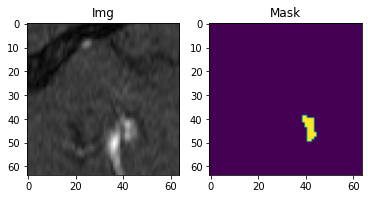

In [ ]:
def display_img_mask(batch_num, img_num):

  for images, labels in train_ds.take(batch_num):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()e)

  plt.subplot(1,2,1)
  plt.imshow(numpy_images[img_num])
  plt.title('Img')

  plt.subplot(1,2,2)
  plt.imshow(numpy_labels[img_num].reshape((64,64)))
  plt.title('Mask')

In [ ]:
display_img_mask(2,25)

In [ ]:
# train_ds and valid_ds are unpacked into images and masks for viewing purposes

train_images = list(train_ds.take(1))
train_masks = np.concatenate([img[1] for img in train_images])
train_images = np.concatenate([img[0] for img in train_images])

val_images = list(val_ds.take(1))
val_masks = np.concatenate([img[1] for img in val_images])
val_images = np.concatenate([img[0] for img in val_images])

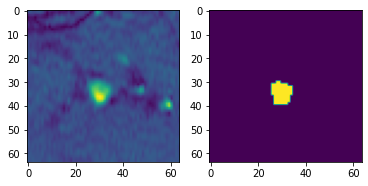

In [ ]:
img_num = 60

plt.subplot(1,2,1)
plt.imshow(train_images[img_num].reshape((64,64)))

plt.subplot(1,2,2)
plt.imshow(train_masks[img_num].reshape((64,64)))

## Loss Function

In [ ]:
# return our metric and loss

with tpu_strategy.scope():

  def dice_coef(y_true, y_pred, smooth=1e-15):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2* intersection + smooth)/(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


  def dice_coef_loss(y_true, y_pred):

    return (1 - dice_coef(y_true, y_pred))


  def mixed_loss(y_true, y_pred):

    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)

    bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f, from_logits=False)
    dice = dice_coef(y_true, y_pred)

    return bce #+ (1 - dice) 

## Model Architecture

### Pre-trained Model: Original

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
def rescale_output(y_pred):

  y_pred = tf.clip_by_value(y_pred, clip_value_min=0., clip_value_max=1.) # force values to be between 0 and 1

  return y_pred

In [ ]:
with tpu_strategy.scope(): 

  def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[64, 64, 3])
    resize_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (96, 96)))
    x = resize_layer(inputs)

    # Downsampling through the model
    base_model = tf.keras.applications.MobileNetV2(input_shape=[96, 96, 3], include_top=False) # ImageNet weights only work with 3 channel images

    # adding regularization
    penalty = 0.01
    regularizer = tf.keras.regularizers.l2(penalty)

    for layer in base_model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # x = base_model(x)
    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 48x48
        'block_3_expand_relu',   # 24x24
        'block_6_expand_relu',   # 12x12
        'block_13_expand_relu',  # 6x6
        'block_16_project',      # 3x3
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(576, 3),  # 4x4 -> 8x8
        pix2pix.upsample(192, 3),  # 8x8 -> 16x16
        pix2pix.upsample(144, 3),  # 16x16 -> 32x32
        pix2pix.upsample(96, 3),   # 32x32 -> 64x64
    ]


    skips = down_stack(x)
    x = skips[-1] # final output of encoder
    skips = reversed(skips[:-1]) # all outputs of encoder except final, reversed
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x) # pass output of encoder through decoder (iterates through outputs of decoder)
      concat = tf.keras.layers.Concatenate() 
      x = concat([x, skip]) # cross-link: output of decoder concatenated with encoder output
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    normalise_output = tf.keras.layers.Lambda(rescale_output)

    x = last(x)
    shrinking_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (64, 64)))
    x = shrinking_layer(x)
    # x = tf.keras.activations.sigmoid(x)
    x = normalise_output(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(output_channels=1)

model.compile(optimizer=AdamW(weight_decay=1e-6, learning_rate=3e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=dice_coef)
# model.summary()
model.predict(tf.expand_dims(img[0], axis=[0])).shape

(1, 64, 64, 1)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# tf.keras.utils.plot_model(base_model, show_shapes=True)
base_model.summary()

### Pre-trained Model with regularisation

In [ ]:
# adding regularization
regularizer = tf.keras.regularizers.l2(penalty)

for layer in base_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

NameError: ignored

## Training the model

### Learning rate scheduler & early stopping

In [ ]:
def build_learning_rate_cycler(
    lr_start=1e-5,
    lr_max=5e-5,
    lr_min=1e-6,
    lr_rampup_epochs=10,
    lr_sustain_epochs=2,
    lr_exp_decay=0.9,
):
    lr_max = lr_max

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (
                epoch - lr_rampup_epochs - lr_sustain_epochs
            ) + lr_min
        return lr

    return lrfn

lr_cycler = build_learning_rate_cycler(
          lr_start=1e-6,
          lr_max=3e-4,
          lr_min=1e-7,
          lr_rampup_epochs=20,
          lr_sustain_epochs=0,
          lr_exp_decay=0.9,
      )


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=20,
                    restore_best_weights=True,
                    mode='auto')

### Find optimal learning rate

In [ ]:
img, label = list(train_ds.take(1))[0]
img.shape, label.shape

(TensorShape([64, 64, 64, 3]), TensorShape([64, 64, 64, 1]))

In [ ]:
model = unet_model(output_channels=1)
          
model.compile(optimizer=AdamW(weight_decay=0, learning_rate=1e-4),
                        loss=tf.keras.losses.binary_crossentropy,
                        metrics=dice_coef)

initial_weights = model.get_weights()
len(initial_weights)

273

In [ ]:
def find_learning_rate(num_rates=50):
    rates = np.logspace(-6, 2, num=num_rates)
    img, label = list(train_ds.take(1))[0]
    losses = []
    for rate in tqdm(rates):
          model = unet_model(output_channels=1)

          model.compile(optimizer=AdamW(weight_decay=0, learning_rate=rate),
                        loss=tf.keras.losses.binary_crossentropy,
                        metrics=dice_coef)
          model.set_weights(initial_weights)
          model.fit(img, label, epochs=5, verbose=0)
          losses.append(model.history.history['loss'][0])
    return losses, rates

losses, rates = find_learning_rate(50)

  0%|          | 0/50 [00:00<?, ?it/s]

(array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <a list of 8 Text major ticklabel objects>)

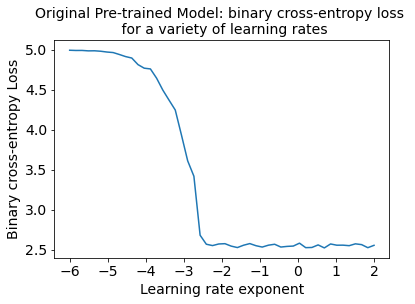

In [ ]:
plt.plot(np.log10(rates), losses)
plt.title('Original Pre-trained Model: binary cross-entropy loss \n for a variety of learning rates', size=14)
plt.xlabel('Learning rate exponent', size=14)
plt.ylabel('Binary cross-entropy Loss', size=14)
plt.xticks(size=14)
plt.yticks(size=14)

### Train on full dataset

In [ ]:
with tpu_strategy.scope():

  model = unet_model(output_channels=1)

  loss = tf.keras.losses.binary_crossentropy # dice_coef_loss # mixed_loss
  metrics = dice_coef

  lr = 1e-4
  weight_decay = 0

  model.compile(optimizer=AdamW(weight_decay=weight_decay, learning_rate=lr), # weight_decay=1e-2 & 1e-3 too big but 1e-4 doesn't improve much
                loss=loss,
                metrics=dice_coef)

  EPOCHS = 100

  history = model.fit(
      train_ds.take(5), 
      epochs=EPOCHS,
      validation_data=val_ds, callbacks=[early_stopping]) 

  # history = model.fit(
  #     train_ds.take(1), 
  #     epochs=EPOCHS) # single batch

  # history = model.fit(train_ds.take(12).shuffle(5000), epochs=EPOCHS,
  #                           validation_data=val_ds.take(4), callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1), WandbCallback(), early_stopping])

Epoch 1/100
5/5 [==============================] - 23s 2s/step - loss: 0.1851 - dice_coef: 0.0076 - val_loss: 0.0952 - val_dice_coef: 0.0045
Epoch 2/100
5/5 [==============================] - 2s 390ms/step - loss: 0.1191 - dice_coef: 0.0092 - val_loss: 0.0696 - val_dice_coef: 0.0052
Epoch 3/100
5/5 [==============================] - 2s 357ms/step - loss: 0.1046 - dice_coef: 0.0096 - val_loss: 0.0638 - val_dice_coef: 0.0043
Epoch 4/100
5/5 [==============================] - 2s 384ms/step - loss: 0.1043 - dice_coef: 0.0094 - val_loss: 0.0631 - val_dice_coef: 0.0025
Epoch 5/100
5/5 [==============================] - 2s 357ms/step - loss: 0.1044 - dice_coef: 0.0055 - val_loss: 0.0631 - val_dice_coef: 0.0016
Epoch 6/100
5/5 [==============================] - 2s 395ms/step - loss: 0.1059 - dice_coef: 0.0063 - val_loss: 0.0630 - val_dice_coef: 0.0013
Epoch 7/100
5/5 [==============================] - 2s 359ms/step - loss: 0.1032 - dice_coef: 0.0059 - val_loss: 0.0630 - val_dice_coef: 0.0013
E

KeyboardInterrupt: ignored

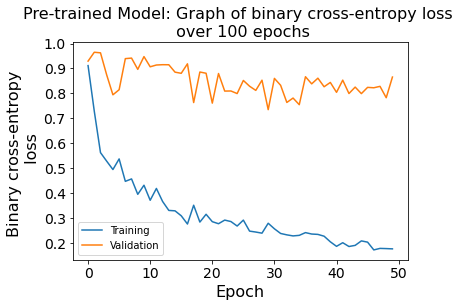

In [ ]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Pre-trained Model: Graph of binary cross-entropy loss \n over 100 epochs', size=16)
plt.xlabel('Epoch', size=16)
plt.ylabel('Binary cross-entropy \n loss', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend()

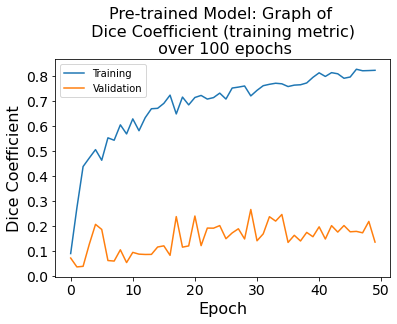

In [ ]:
plt.plot(history.history['dice_coef'], label='Training')
plt.plot(history.history['val_dice_coef'], label='Validation')
plt.title('Pre-trained Model: Graph of \n Dice Coefficient (training metric) \n over 100 epochs', size=16)
plt.xlabel('Epoch', size=16)
plt.ylabel('Dice Coefficient', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend()

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
 <a list of 7 Text major ticklabel objects>)

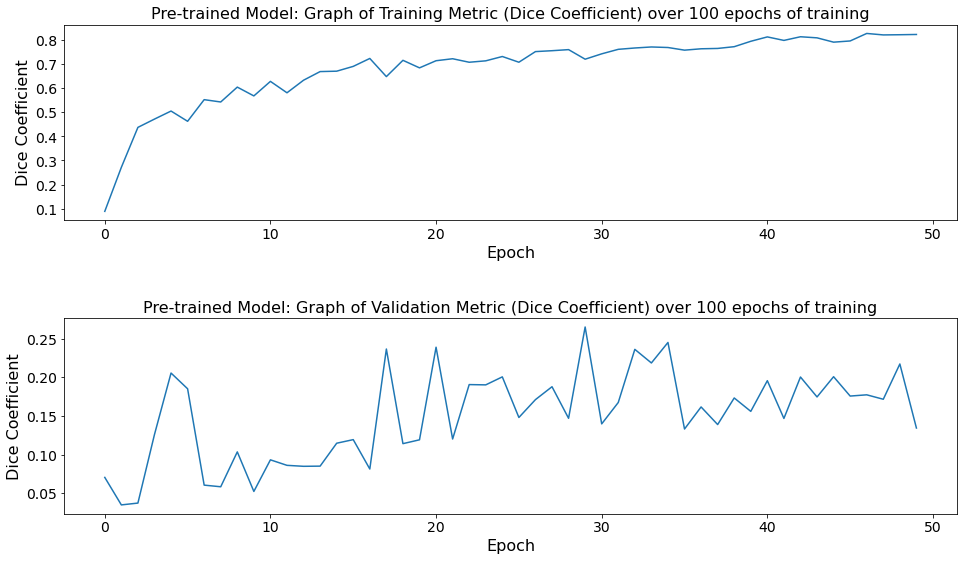

In [ ]:
plt.figure(figsize=(16, 9)) 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

plt.subplot(2,1,1)
plt.plot(history.history['dice_coef'])
plt.title('Pre-trained Model: Graph of Training Metric (Dice Coefficient) over 100 epochs of training', size=16)
plt.xlabel('Epoch', size=16)
plt.ylabel('Dice Coefficient', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(2,1,2)
plt.plot(history.history['val_dice_coef'])
plt.title('Pre-trained Model: Graph of Validation Metric (Dice Coefficient) over 100 epochs of training', size=16)
plt.xlabel('Epoch', size=16)
plt.ylabel('Dice Coefficient', size=16)
plt.xticks(size=14)
plt.yticks(size=14)


# Model Evaluation

## Load test set

In [ ]:
print('Loading and preprocessing test data (non-empty masks)...')

test_non_empty_gcs_pattern = "gs://tf_records_patches_64by64/tfrecordstest_non_empty*"
test_non_empty_filenames = tf.io.gfile.glob(test_non_empty_gcs_pattern)
test_non_empty_ds = tf.data.TFRecordDataset(test_non_empty_filenames)

test_non_empty_ds = test_non_empty_ds.map(_parse_image_function)
test_non_empty_ds = test_non_empty_ds.map(_unpack_proto)
test_non_empty_ds = test_non_empty_ds.map(to_3_channels)

test_ds = prepare_data(test_non_empty_ds)

Loading and preprocessing test data (non-empty masks)...


In [ ]:
test_pairs = list(test_ds.take(1))

test_images = [pair[0] for pair in test_pairs]
test_images_to_display = np.concatenate(test_images)

test_masks_orig = [pair[1] for pair in test_pairs]
test_masks_orig = np.concatenate(test_masks_orig)

In [ ]:
test_images[0].shape

TensorShape([38, 64, 64, 3])

## Generate predictions on test set

In [ ]:
def compare_img_mask(img_num):

  """
  Display original image with mask, true mask and predicted mask for a specified image number
  
  Args:
  train_, test_ or valid_ + images/masks/preds
  """
  
  plt.figure(figsize=(20, 4)) 

  plt.subplot(1,3,1)
  a = rescale_intensity(test_images_to_display[img_num]) # image
  b = test_masks_orig[img_num].reshape((64,64)) # mask
  plt.imshow(mark_boundaries(a,b, mode='thick')) # display image with mask overlaid
  plt.title('Original image patch \n (True mask outlined \n in yellow)', size=18)

  plt.subplot(1,3,2)
  plt.imshow(test_masks_orig[img_num].reshape((64,64)), cmap='gray')
  plt.title('True mask', size=18)

  plt.subplot(1,3,3)
  plt.imshow(np.round(test_preds[img_num].reshape((64,64))), cmap='gray')
  plt.title('Predicted mask', size=18)

In [ ]:
print('Predicting masks on test data...')

test_preds = [model.predict(batch) for batch in test_images]
test_preds = np.concatenate(test_preds)

Predicting masks on test data...


In [ ]:
# calculate dice coeff for each pair of true (test_masks) and predicted (test_preds) masks in the test set

dice_coeff_list = []
dice_coeff_dict = {}

for i in range(len(test_masks_orig)):
  true_mask = test_masks_orig[i]
  pred_mask = test_preds[i].reshape((64,64))
  pred_mask = np.round(pred_mask)

  dice_coeff = np.array(dice_coef(true_mask, pred_mask))
  dice_coeff_list.append(dice_coeff)
  dice_coeff_dict[i] = dice_coeff

np.mean(dice_coeff_list), np.std(dice_coeff_list)

(nan, nan)

Text(0, 0.5, 'Number of Images')

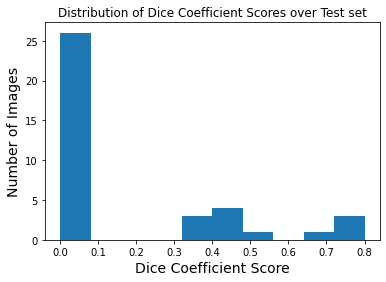

In [ ]:
plt.hist(dice_coeff_list)
plt.title('Distribution of Dice Coefficient Scores over Test set')
plt.xlabel('Dice Coefficient Score', size=14)
plt.ylabel('Number of Images', size=14)

In [ ]:
# create lists 'low' and 'high' that store indices of low and high scoring masks respectively

low = []
med = []
high = []

for key,val in dice_coeff_dict.items():
  if val<0.1:
    low.append(key)
  elif val<0.5 and val>0.3:
    med.append(key)
  elif val>0.5:
    high.append(key)


len(low), len(med), len(high)

(26, 7, 5)

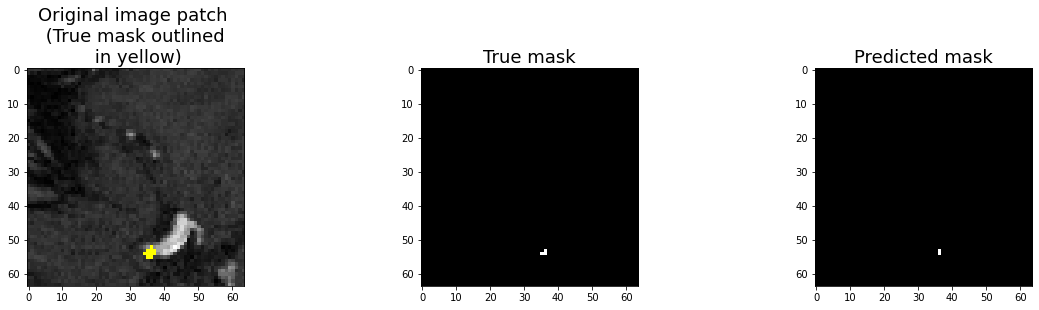

In [ ]:
compare_img_mask(23) # high

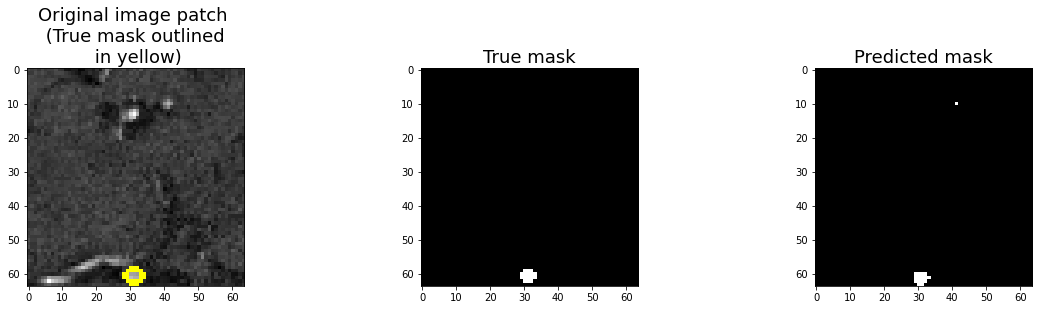

In [ ]:
compare_img_mask(8) # high

In [ ]:
high

[1, 3, 8, 23, 30]

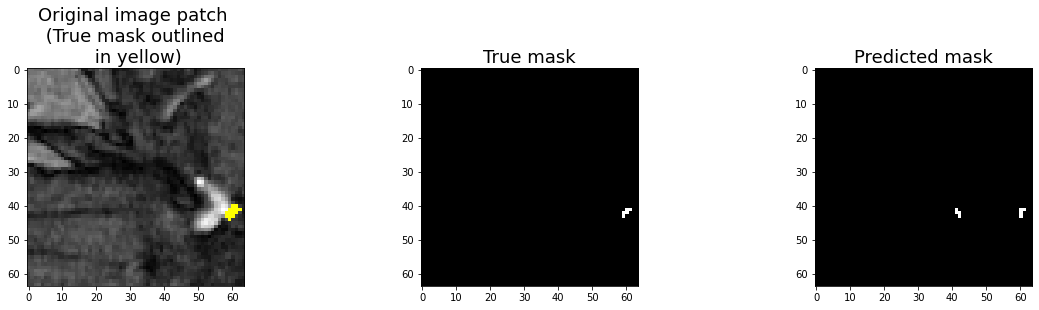

In [ ]:
compare_img_mask(16) # med

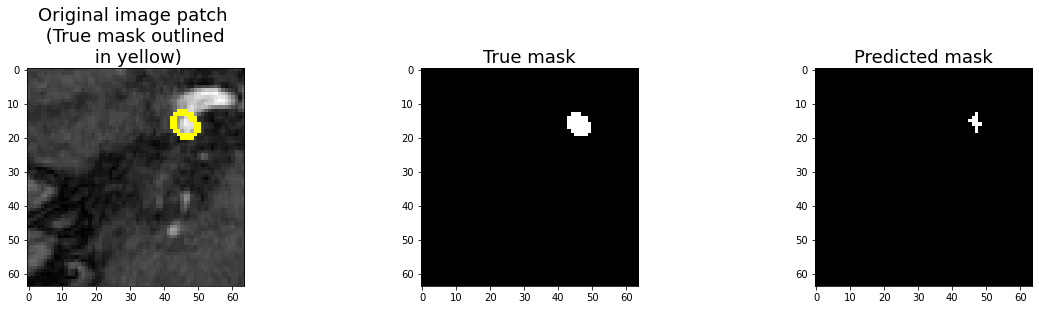

In [ ]:
compare_img_mask(2) # med

## Other Metrics

In [ ]:
# Hausdorff Distance

from scipy.spatial.distance import directed_hausdorff

img_num = 32

u = test_images_to_display[img_num].reshape((64,64))
v = test_preds[img_num].reshape((64,64))

# v = np.where(v>0.5,1,0)

directed_hausdorff(u,v)[0]

2.5608472089575742

In [ ]:
labelPred=sitk.GetImageFromArray(v, isVector=False)
labelTrue=sitk.GetImageFromArray(u, isVector=False)

hausdorffcomputer = sitk.HausdorffDistanceImageFilter()

# hausdorffcomputer.Execute(labelPred>0.5,labelTrue>0.5)
hausdorffcomputer.Execute(labelPred,labelTrue)

hausdorffcomputer.GetAverageHausdorffDistance()

7.573977428884182

In [ ]:
dicecomputer=sitk.LabelOverlapMeasuresImageFilter()
dicecomputer.Execute(labelTrue>0.5,labelPred>0.5)
dicecomputer.GetDiceCoefficient()

0.18666666666666665